[Original author](https://designwith.ml/assets/docs/Meetup_clustering_sample)  
  
Clustering meetup.com data! Using the location and group information to cluster the members into 6 clusters - but it is up to you to figure out what they mean!  

Data was on Kaggle.

In [1]:
#these are all of the libraries i'll be using - and I load the groups.csv data
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [6]:
import pandas as pd

df = pd.read_csv("groups.csv")

# Data Step
This step we're going to look at our dataframes and become familiar with what's in them.

In [7]:
#this is what the groups.csv looks like as a dataframe - it is about the groups
df.head()

group_id  category_id          category.name     category.shortname  \
0      6388           14       health/wellbeing       health-wellbeing   
1      6510            4  community/environment  community-environment   
2      8458           26           pets/animals           pets-animals   
3      8940           29         sci-fi/fantasy         sci-fi-fantasy   
4     10104           26           pets/animals           pets-animals   

   city_id      city country              created  \
0    10001  New York      US  2002-11-21 16:50:46   
1    10001  New York      US  2003-05-20 14:48:54   
2    10001  New York      US  2004-03-27 09:55:41   
3    10001  New York      US  2002-11-16 04:49:16   
4    10001  New York      US  2003-10-22 21:39:49   

                                         description  \
0  Those who practice or hold a strong interest i...   
1  The New York Alternative Energy Meetupis for t...   
2                                          not_found   
3  Welcome to the The New York City Anime Meetup ...   
4  We welcome those who support pits, even if you...   

              group_photo.base_url  ...  \
0  https://secure.meetupstatic.com  ...   
1  https://secure.meetupstatic.com  ...   
2  https://secure.meetupstatic.com  ...   
3  https://secure.meetupstatic.com  ...   
4  https://secure.meetupstatic.com  ...   

                          organizer.photo.photo_link  \
0  https://secure.meetupstatic.com/photos/member/...   
1  https://secure.meetupstatic.com/photos/member/...   
2  https://secure.meetupstatic.com/photos/member/...   
3  https://secure.meetupstatic.com/photos/member/...   
4  https://secure.meetupstatic.com/photos/member/...   

                          organizer.photo.thumb_link organizer.photo.type  \
0  https://secure.meetupstatic.com/photos/member/...               member   
1  https://secure.meetupstatic.com/photos/member/...               member   
2  https://secure.meetupstatic.com/photos/member/...               member   
3  https://secure.meetupstatic.com/photos/member/...               member   
4  https://secure.meetupstatic.com/photos/member/...               member   

  rating state    timezone                    urlname utc_offset  \
0   4.39    NY  US/Eastern     alternative-health-nyc     -14400   
1   4.31    NY  US/Eastern  alternative-energy-meetup     -14400   
2   4.84    NY  US/Eastern                    Animals     -14400   
3   4.46    NY  US/Eastern                  NYC-Anime     -14400   
4   4.09    NY  US/Eastern                NYC-Pitbull     -14400   

       visibility                            who  
0          public            Explorers of Health  
1          public        Clean Energy Supporters  
2          public                  Animal Voices  
3          public                     Anime Fans  
4  public_limited  NYC Pits & People, Dog Lovers  

[5 rows x 36 columns]

In [9]:
#this is the df about the members
df2 = pd.read_csv("members.csv", encoding = "ISO-8859-1" , nrows=1600133) #  This encoding is commonly used for Western European languages and is a single-byte encoding that can represent a wide range of characters, including characters with accents and diacritics.

In [10]:
df2.shape

(1600133, 14)

In [11]:
df2.head()

member_id                                                bio      city  \
0          3                                          not_found  New York   
1          3                                          not_found  New York   
2          3  Hi, I'm Matt. I'm an entrepreneur who has star...  New York   
3          3  Hi, I'm Matt. I'm an entrepreneur who has star...  New York   
4          3  Hi, I'm Matt. I'm an entrepreneur who has star...  New York   

  country      hometown               joined    lat  \
0      us  New York, NY  2007-05-01 22:04:37  40.72   
1      us  New York, NY  2011-01-23 14:13:17  40.72   
2      us  New York, NY  2010-12-30 18:47:34  40.72   
3      us  New York, NY  2011-01-03 14:45:21  40.72   
4      us  New York, NY  2010-12-30 18:34:50  40.72   

                              link   lon  member_name state member_status  \
0  http://www.meetup.com/members/3 -74.0  Matt Meeker    NY        active   
1  http://www.meetup.com/members/3 -74.0  Matt Meeker    NY        active   
2  http://www.meetup.com/members/3 -74.0  Matt Meeker    NY        active   
3  http://www.meetup.com/members/3 -74.0  Matt Meeker    NY        active   
4  http://www.meetup.com/members/3 -74.0  Matt Meeker    NY        active   

               visited  group_id  
0  2009-09-18 18:32:23    490552  
1  2011-03-20 01:02:11   1474611  
2  2011-01-18 20:37:23   1490492  
3  2011-07-23 03:42:28   1515830  
4  2011-06-13 18:33:23   1574965

## Data Cleaning Phase
In this phase, we'll sample a % of the data, and then use "one hot" encoding to turn string features into numbers for our mathematical models.

In [12]:
# I am sampling to 5,000 random samples from the dataframe since it is just SOOO big! This will help my code run faster
df2_sample = df2.sample(n=5000)

In [13]:
#let's explore the df by member id and the first record number of each - what are the features we want to use?
# group a DataFrame (df2_sample) by the 'member_id' column and then select the first row within each group.
# This operation is often used to get the first entry or a representative entry for each unique member ID.
df2_sample.groupby(['member_id']).first()

bio  \
member_id                                                      
4368                                               not_found   
46847                                              not_found   
70644                                              not_found   
92040                          Build manager for a C# house.   
98404                                              not_found   
...                                                      ...   
48387712                                           not_found   
48389762   Not quite a San Francisco native, though 20 ye...   
48451772                                           not_found   
48507722                                           not_found   
48534792              Hey everypony.  I am such a huge brony   

                          city country          hometown               joined  \
member_id                                                                       
4368                   Chicago      us           Chicago  2006-05-11 04:12:27   
46847            San Francisco      us  Cedar Rapids, IA  2015-12-07 22:16:27   
70644                 New York      us     New York City  2015-06-25 15:18:14   
92040                 New York      us         not_found  2013-05-17 02:45:20   
98404                 New York      us          New York  2008-04-11 22:27:01   
...                        ...     ...               ...                  ...   
48387712   South San Francisco      us         not_found  2017-10-29 20:35:12   
48389762         San Francisco      us         not_found  2012-05-19 10:02:19   
48451772              New York      us         not_found  2015-11-15 22:44:23   
48507722         San Francisco      us      Philadelphia  2015-10-18 19:12:36   
48534792              New York      us         not_found  2013-05-13 04:49:23   

             lat                                    link     lon  \
member_id                                                          
4368       41.92      http://www.meetup.com/members/4368  -87.70   
46847      37.78     http://www.meetup.com/members/46847 -122.49   
70644      40.73     http://www.meetup.com/members/70644  -73.99   
92040      40.75     http://www.meetup.com/members/92040  -73.99   
98404      40.79     http://www.meetup.com/members/98404  -73.98   
...          ...                                     ...     ...   
48387712   37.65  http://www.meetup.com/members/48387712 -122.43   
48389762   37.76  http://www.meetup.com/members/48389762 -122.44   
48451772   40.73  http://www.meetup.com/members/48451772  -74.01   
48507722   37.77  http://www.meetup.com/members/48507722 -122.40   
48534792   40.74  http://www.meetup.com/members/48534792  -73.99   

                member_name state member_status              visited  group_id  
member_id                                                                       
4368                  Steve    IL        active  2013-04-17 17:28:36    122646  
46847         Marie Janssen    CA        active  2015-12-07 22:16:27  19188690  
70644               rna2600    NY        active  2017-05-22 13:35:10  18689563  
92040          Anne Moroney    NY        active  2014-06-04 12:55:11   6595102  
98404                  Jaki    NY        active  2008-04-11 22:27:01    228200  
...                     ...   ...           ...                  ...       ...  
48387712          Eva-Maria    CA        active  2016-01-02 14:06:54  18515732  
48389762             Martin    CA        active  2012-05-19 10:02:19   2148441  
48451772             louisa    NY        active  2017-09-16 19:57:33   1688687  
48507722   Christine Joseph    CA        active  2015-10-18 19:12:36   2727952  
48534792       thomas lyman    NY        active  2015-08-10 16:44:06   3168022  

[4766 rows x 13 columns]

df2_sample['group_id']: This extracts the 'group_id' column from the DataFrame df2_sample.  
pd.get_dummies(...): This function converts categorical variable(s) into dummy/indicator variables. In this case, it's applied to the 'group_id' column.  
prefix='group_id': This parameter adds a prefix to the newly created dummy variable columns to indicate their association with the original 'group_id'.  
  
  The resulting df2_sample_dummies DataFrame will contain new binary columns (0 or 1) for each unique value in the 'group_id' column. Each row will have a 1 in the column corresponding to its 'group_id' and 0s in the other columns.

In [14]:
#One feature I want to use is the GROUP ID - one thing that we can do is "get dummies" or "one-hot encoding" to
#turn string variables into numbers! look at it below
df2_sample_dummies = pd.get_dummies(df2_sample['group_id'], prefix = 'group_id')

In [15]:
#this is what it looks like to have "dummies" or one-hot encoded variables!
df2_sample_dummies.head()

group_id_6510  group_id_8458  group_id_12907  group_id_14573  \
1267001          False          False           False           False   
622550           False          False           False           False   
1041470          False          False           False           False   
351758           False          False           False           False   
15343            False          False           False           False   

         group_id_22211  group_id_24765  group_id_25727  group_id_26217  \
1267001           False           False           False           False   
622550            False           False           False           False   
1041470           False           False           False           False   
351758            False           False           False           False   
15343             False           False           False           False   

         group_id_26415  group_id_26434  ...  group_id_26080463  \
1267001           False           False  ...              False   
622550            False           False  ...              False   
1041470           False           False  ...              False   
351758            False           False  ...              False   
15343             False           False  ...              False   

         group_id_26128668  group_id_26133735  group_id_26157712  \
1267001              False              False              False   
622550               False              False              False   
1041470              False              False              False   
351758               False              False              False   
15343                False              False              False   

         group_id_26187030  group_id_26220234  group_id_26233938  \
1267001              False              False              False   
622550               False              False              False   
1041470              False              False              False   
351758               False              False              False   
15343                False              False              False   

         group_id_26235923  group_id_26254833  group_id_26342343  
1267001              False              False              False  
622550               False              False              False  
1041470              False              False              False  
351758               False              False              False  
15343                False              False              False  

[5 rows x 2696 columns]

In [16]:
#Let's combine it back to our original dataframe
df2_sample_dummies_concat = pd.concat([df2_sample, df2_sample_dummies], axis=1)

In [17]:
df2_sample_dummies_concat.head()

member_id        bio           city country         hometown  \
1267001   22499121  not_found  San Francisco      us        not_found   
622550     9842552  not_found       New York      us  Dublin, Ireland   
1041470   13663146  not_found       New York      us         New York   
351758     6729024  not_found       New York      us        not_found   
15343       498421  not_found       New York      us         New York   

                      joined    lat                                    link  \
1267001  2016-01-18 22:24:49  37.78  http://www.meetup.com/members/22499121   
622550   2017-07-18 16:31:32  40.72   http://www.meetup.com/members/9842552   
1041470  2015-12-26 13:17:01  40.74  http://www.meetup.com/members/13663146   
351758   2011-05-03 19:35:15  40.72   http://www.meetup.com/members/6729024   
15343    2003-08-05 06:50:22  40.72    http://www.meetup.com/members/498421   

            lon      member_name  ... group_id_26080463 group_id_26128668  \
1267001 -122.42            Jason  ...             False             False   
622550   -74.00      Niall Smart  ...             False             False   
1041470  -74.00    Edward Daciuk  ...             False             False   
351758   -74.00  Stephen Klenert  ...             False             False   
15343    -74.00                G  ...             False             False   

        group_id_26133735  group_id_26157712  group_id_26187030  \
1267001             False              False              False   
622550              False              False              False   
1041470             False              False              False   
351758              False              False              False   
15343               False              False              False   

         group_id_26220234  group_id_26233938  group_id_26235923  \
1267001              False              False              False   
622550               False              False              False   
1041470              False              False              False   
351758               False              False              False   
15343                False              False              False   

         group_id_26254833  group_id_26342343  
1267001              False              False  
622550               False              False  
1041470              False              False  
351758               False              False  
15343                False              False  

[5 rows x 2710 columns]

In [18]:
#let's repeat the same process for the "cities" feature
df2_sample_dummies_cities = pd.get_dummies(df2_sample_dummies_concat['city'], prefix = 'cities_')
df2_sample_dummies_concat_cities2 = pd.concat([df2_sample_dummies_concat, df2_sample_dummies_cities], axis=1)

In [19]:
df2_sample_dummies_concat_cities2.head()

member_id        bio           city country         hometown  \
1267001   22499121  not_found  San Francisco      us        not_found   
622550     9842552  not_found       New York      us  Dublin, Ireland   
1041470   13663146  not_found       New York      us         New York   
351758     6729024  not_found       New York      us        not_found   
15343       498421  not_found       New York      us         New York   

                      joined    lat                                    link  \
1267001  2016-01-18 22:24:49  37.78  http://www.meetup.com/members/22499121   
622550   2017-07-18 16:31:32  40.72   http://www.meetup.com/members/9842552   
1041470  2015-12-26 13:17:01  40.74  http://www.meetup.com/members/13663146   
351758   2011-05-03 19:35:15  40.72   http://www.meetup.com/members/6729024   
15343    2003-08-05 06:50:22  40.72    http://www.meetup.com/members/498421   

            lon      member_name  ... group_id_26220234 group_id_26233938  \
1267001 -122.42            Jason  ...             False             False   
622550   -74.00      Niall Smart  ...             False             False   
1041470  -74.00    Edward Daciuk  ...             False             False   
351758   -74.00  Stephen Klenert  ...             False             False   
15343    -74.00                G  ...             False             False   

        group_id_26235923  group_id_26254833  group_id_26342343  \
1267001             False              False              False   
622550              False              False              False   
1041470             False              False              False   
351758              False              False              False   
15343               False              False              False   

         cities__Chicago  cities__New York  cities__San Francisco  \
1267001            False             False                   True   
622550             False              True                  False   
1041470            False              True                  False   
351758             False              True                  False   
15343              False              True                  False   

         cities__South San Francisco  cities__West New York  
1267001                        False                  False  
622550                         False                  False  
1041470                        False                  False  
351758                         False                  False  
15343                          False                  False  

[5 rows x 2715 columns]

In [20]:
#write it to a CSV before your kernel dies! this could be helpful if you want to use the same sample again in the future
df2_sample_dummies_concat_cities2.to_csv('members2.csv')


In [29]:
print(df2_sample_dummies_concat_cities2.columns)


Index(['member_id', 'bio', 'city', 'country', 'hometown', 'joined', 'lat',
       'link', 'lon', 'member_name',
       ...
       'group_id_26220234', 'group_id_26233938', 'group_id_26235923',
       'group_id_26254833', 'group_id_26342343', 'cities__Chicago',
       'cities__New York', 'cities__San Francisco',
       'cities__South San Francisco', 'cities__West New York'],
      dtype='object', length=2715)


## Training the model
We will use groupIDs and Cities as our main features to train the model - and since we want the data itself to group and tell us what the major groups are - we are going to use a technique called "clustering" (or k-means clustering, where k= the number of clusters). I don't know in advance what the best number of clusters will be, so I will try a bunch of different k (k= 2,4,6,8) and then see how well our clusters are performing. See below :)

In [31]:
df2_sample_dummies_concat_cities2_train = df2_sample_dummies_concat_cities2.loc[:, "group_id_6388":"cities__West New York"]
df2_sample_dummies_concat_cities2_train.head()

KeyError: 'group_id_6388'

In [21]:
#k = 8 training model
km = KMeans(n_clusters=8)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k8 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 8.04 s, sys: 1.45 s, total: 9.49 s
Wall time: 5.49 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 7.39 s, sys: 840 ms, total: 8.23 s
Wall time: 4.45 s


In [23]:
#k=6 training model
km = KMeans(n_clusters=6)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k6 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 5.77 s, sys: 904 ms, total: 6.68 s
Wall time: 3.68 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 4.35 s, sys: 477 ms, total: 4.83 s
Wall time: 6.75 s


In [24]:
# k = 4 training model
km = KMeans(n_clusters=4)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k4 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 4.41 s, sys: 1.04 s, total: 5.44 s
Wall time: 3.01 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 3.73 s, sys: 784 ms, total: 4.52 s
Wall time: 4 s


In [25]:
# k = 2 training model
km = KMeans(n_clusters=2)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters = km.labels_.tolist()
%time km.fit(df2_sample_dummies_concat_cities2_train)
silhouette_k2 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:5000], clusters[0:5000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 2.73 s, sys: 849 ms, total: 3.58 s
Wall time: 2.02 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 3.14 s, sys: 971 ms, total: 4.11 s
Wall time: 2.31 s


## Model Evaluation


In [26]:
silhouette = [silhouette_k2, silhouette_k4, silhouette_k6, silhouette_k8]
count_k = [2, 4, 6, 8]

count_silhouette = list(zip(count_k, silhouette))
print(count_silhouette)

[(2, 0.23463933792138547), (4, 0.2929464113392071), (6, 0.050261011404846206), (8, 0.10947864946162009)]


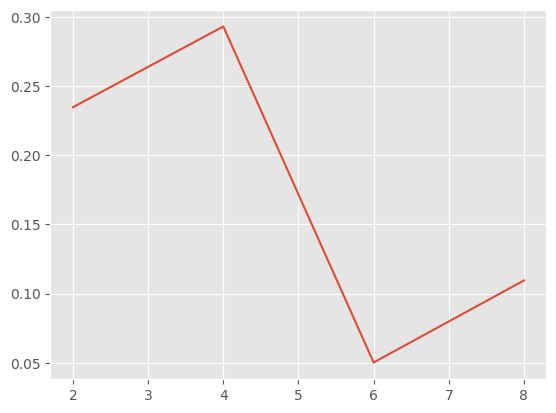

In [27]:
plt.plot(*zip(*count_silhouette))

* No Clear Elbow:
If the inertia plot doesn't show a clear elbow and the inertia decreases smoothly without a significant break point, it might be challenging to determine the optimal k based solely on this method.  
  
* Slight Elbow:
If there's a slight elbow, it suggests that adding more clusters beyond that point provides diminishing returns in terms of explaining the variance in the data.  
  
* Sharp Elbow:
If there's a sharp elbow, it indicates a more pronounced point where the addition of clusters is less beneficial. This is often considered a good candidate for the optimal number of clusters.  

  However, it's important to note that the elbow method has limitations, and the choice of k may not always be entirely clear-cut. It's often used as a heuristic rather than a strict rule. Other factors, such as domain knowledge, the context of the problem, and the specific characteristics of the data, should also be considered.

## Model Output
Now that we've decided on k=4 clusters, let's assign the cluster labels back to the original data, and make it interpretable!

In [28]:
km = KMeans(n_clusters=4)
%time km.fit(df2_sample_dummies_concat_cities2_train)
clusters4 = km.labels_.tolist()
silhouette_k4 = silhouette_score(df2_sample_dummies_concat_cities2_train[0:50000], clusters[0:50000])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 3.65 s, sys: 449 ms, total: 4.1 s
Wall time: 7.1 s


In [29]:
df2_sample_dummies_concat_cities2_train.loc[:, "cluster_number"] = clusters4

In [30]:
df2_sample_dummies_concat_cities2_train.head()

group_id_6388  group_id_6510  group_id_8458  group_id_8940  \
905931               0              0              0              0   
1553078              0              0              0              0   
344590               0              0              0              0   
1223707              0              0              0              0   
989028               0              0              0              0   

         group_id_12542  group_id_12907  group_id_15324  group_id_22211  \
905931                0               0               0               0   
1553078               0               0               0               0   
344590                0               0               0               0   
1223707               0               0               0               0   
989028                0               0               0               0   

         group_id_24765  group_id_25709  ...  group_id_26301058  \
905931                0               0  ...                  0   
1553078               0               0  ...                  0   
344590                0               0  ...                  0   
1223707               0               0  ...                  0   
989028                0               0  ...                  0   

         group_id_26341790  cities__Chicago  cities__Chicago Heights  \
905931                   0                1                        0   
1553078                  0                0                        0   
344590                   0                0                        0   
1223707                  0                0                        0   
989028                   0                0                        0   

         cities__New York  cities__San Francisco  cities__South San Francisco  \
905931                  0                      0                            0   
1553078                 1                      0                            0   
344590                  0                      1                            0   
1223707                 1                      0                            0   
989028                  0                      1                            0   

         cities__West Chicago  cities__West New York  cluster_number  
905931                      0                      0               1  
1553078                     0                      0               3  
344590                      0                      0               2  
1223707                     0                      0               3  
989028                      0                      0               2  

[5 rows x 2720 columns]

In [31]:
df2_sample_dummies_concat_cities2_train["cluster_number"].value_counts()

3    2929
2    1257
1     794
0      20
Name: cluster_number, dtype: int64

## Tadah! We have a merged dataframe of members, clustered by their city and groups they're interested in, merged on what the group categories are (from the original groups df) and we can now export this and explore!

In [32]:
df2_sample.head()

member_id        bio           city country       hometown  \
905931    12551969  not_found        Chicago      us  San Francisco   
1553078   44843142  not_found       New York      us      not_found   
344590     6591023  not_found  San Francisco      us  San Francisco   
1223707   19087351  not_found       New York      us      not_found   
989028    13260862  not_found  San Francisco      us  San Francisco   

                      joined    lat                                    link  \
905931   2015-01-11 21:00:19  41.88  http://www.meetup.com/members/12551969   
1553078  2016-01-15 14:33:53  40.75  http://www.meetup.com/members/44843142   
344590   2015-06-26 21:32:53  37.80   http://www.meetup.com/members/6591023   
1223707  2016-08-20 20:16:19  40.75  http://www.meetup.com/members/19087351   
989028   2014-10-09 22:06:49  37.77  http://www.meetup.com/members/13260862   

            lon      member_name state member_status              visited  \
905931   -87.62             Eric    IL        active  2016-11-19 21:15:35   
1553078  -73.99  Bill Pecoriello    NY        active  2016-01-15 14:33:53   
344590  -122.40             Olle    CA        active  2015-07-15 14:03:16   
1223707  -73.99             Tish    NY        active  2016-08-20 20:16:19   
989028  -122.44   Asher Blumberg    CA        active  2015-09-29 00:23:12   

         group_id  
905931    1741214  
1553078   3736372  
344590   18692118  
1223707  19851643  
989028    6230762

In [34]:
df2_sample.loc[:, "clusters_number"] = clusters4

In [35]:
df2_sample.to_csv('members_cluster_group.csv')

In [36]:
!cp members_cluster_group.csv "gdrive/My Drive/Work/UBB 2023/02_Cursuri/Session #5/data/"

In [38]:
df2_sample.head()

member_id        bio           city country       hometown  \
905931    12551969  not_found        Chicago      us  San Francisco   
1553078   44843142  not_found       New York      us      not_found   
344590     6591023  not_found  San Francisco      us  San Francisco   
1223707   19087351  not_found       New York      us      not_found   
989028    13260862  not_found  San Francisco      us  San Francisco   

                      joined    lat                                    link  \
905931   2015-01-11 21:00:19  41.88  http://www.meetup.com/members/12551969   
1553078  2016-01-15 14:33:53  40.75  http://www.meetup.com/members/44843142   
344590   2015-06-26 21:32:53  37.80   http://www.meetup.com/members/6591023   
1223707  2016-08-20 20:16:19  40.75  http://www.meetup.com/members/19087351   
989028   2014-10-09 22:06:49  37.77  http://www.meetup.com/members/13260862   

            lon      member_name state member_status              visited  \
905931   -87.62             Eric    IL        active  2016-11-19 21:15:35   
1553078  -73.99  Bill Pecoriello    NY        active  2016-01-15 14:33:53   
344590  -122.40             Olle    CA        active  2015-07-15 14:03:16   
1223707  -73.99             Tish    NY        active  2016-08-20 20:16:19   
989028  -122.44   Asher Blumberg    CA        active  2015-09-29 00:23:12   

         group_id  clusters_number  
905931    1741214                1  
1553078   3736372                3  
344590   18692118                2  
1223707  19851643                3  
989028    6230762                2

In [39]:
df2_sample['city'].nunique()

7

In [40]:
df2_sample['group_id'].nunique()

2712